In [29]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [30]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

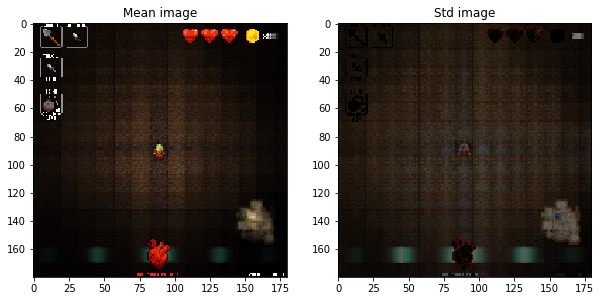

In [31]:
dset_mean = np.load("stats/dsetMean.npy")
dset_std = np.load("stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [32]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 180, 180) (3, 180, 180)


Finally, calculate the mean and std over the three image channels.

In [33]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255 #TODO: just conver to tensor so that you don't have to do this division manually

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.11977421 0.07896504 0.05313502]
Per-channel stds:
[0.13864716 0.09846674 0.08408457]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [36]:
image_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize(channel_means, channel_stds)
])

dataset = datasets.DatasetFolder(root='classes/numpy', extensions=['npy'], loader=np.load, transform=image_transform)
# train_dataset = datasets.ImageFolder(root='classes/images', transform=image_transform)
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))

num_val = num_train//10

permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Training set has 4720 examples.


In [40]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images[0].shape)
print(dset_mean.shape)

plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))

# plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

torch.Size([3, 180, 180])
(3, 180, 180)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fae942236a8> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

# Define training and validation functions

In [41]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50000

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cpu


In [42]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))

In [43]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_model_accuracy(train_loader, model, 'Train')
                check_model_accuracy(val_loader, model, 'Val')
                print()

# Define model

In [44]:
hidden_layer_size = 4000
learning_rate = 1e-3

num_classes = 4

model = nn.Sequential(
    nn.Conv2d(3, 32, 6, stride=3, padding=9), # 32x64x64
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, stride=1, padding=1), # 16x64x64
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, stride=2, padding=0), # 16x32x32
    nn.ReLU(),
#     nn.Conv2d(32, 16, 3, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(16, 16, 3, padding=1),
#     nn.ReLU(),
    Flatten(),
    nn.Linear(16*32*32, num_classes),
)

# you can use Nesterov momentum in optim.SGD
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())


# Train on the dataset!

In [45]:
train_model(model, optimizer, epochs=30)

Iteration 0, loss = 1.3783
Train set: Got 1520 / 4248 correct (35.78)
Val set: Got 163 / 472 correct (34.53)

Iteration 0, loss = 1.0370
Train set: Got 2591 / 4248 correct (60.99)
Val set: Got 257 / 472 correct (54.45)

Iteration 0, loss = 0.6477
Train set: Got 3075 / 4248 correct (72.39)
Val set: Got 296 / 472 correct (62.71)

Iteration 0, loss = 0.6191
Train set: Got 3303 / 4248 correct (77.75)
Val set: Got 307 / 472 correct (65.04)

Iteration 0, loss = 0.5134
Train set: Got 3415 / 4248 correct (80.39)
Val set: Got 316 / 472 correct (66.95)

Iteration 0, loss = 0.4251
Train set: Got 3595 / 4248 correct (84.63)
Val set: Got 330 / 472 correct (69.92)

Iteration 0, loss = 0.3038
Train set: Got 3766 / 4248 correct (88.65)
Val set: Got 334 / 472 correct (70.76)

Iteration 0, loss = 0.3281
Train set: Got 3767 / 4248 correct (88.68)
Val set: Got 348 / 472 correct (73.73)

Iteration 0, loss = 0.2710
Train set: Got 3806 / 4248 correct (89.60)
Val set: Got 347 / 472 correct (73.52)

Iteration 